## Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.dask

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import scipy

import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, SSHCluster
import dask.distributed

import dask_ml
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import LabelEncoder

import xgboost as xgb

import mpl_scatter_density
import matplotlib.colors as colors

import csv
from scipy.spatial.distance import jensenshannon as JS

## Setting up the cluster

In [2]:
# cluster.close()

In [3]:
cluster = SSHCluster(["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": 4,
                                    "nthreads": 1}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                    )

2023-06-30 19:59:31,226 - distributed.deploy.ssh - INFO - 2023-06-30 19:59:31,224 - distributed.scheduler - INFO - State start
2023-06-30 19:59:31,244 - distributed.deploy.ssh - INFO - 2023-06-30 19:59:31,243 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-4300zkz2', purging
2023-06-30 19:59:31,263 - distributed.deploy.ssh - INFO - 2023-06-30 19:59:31,263 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-h_5z0mg0', purging
2023-06-30 19:59:31,333 - distributed.deploy.ssh - INFO - 2023-06-30 19:59:31,332 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ua0zyx0i', purging
2023-06-30 19:59:31,346 - distributed.deploy.ssh - INFO - 2023-06-30 19:59:31,345 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-quvtyr3j', purging
2023-06-30 19:59:31,352 - distributed.deploy.ssh - INFO - 2023

In [4]:
client=Client(cluster)

/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/client.py:1388: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+------------------+
| Package | Client | Scheduler | Workers          |
+---------+--------+-----------+------------------+
| tornado | 6.3.2  | 6.3.2     | {'6.2', '6.3.2'} |
+---------+--------+-----------+------------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [5]:
client

<Client: 'tcp://10.67.22.140:8786' processes=20 threads=20, memory=38.78 GiB>

## Data

In [6]:
n_bins = 100
bhbh_train = dd.read_parquet('/home/ubuntu/train/*')
bhbh_test = dd.read_parquet('/home/ubuntu/test/*')

## Sample weigths

In [7]:
countings = bhbh_train['label'].to_frame().groupby('label').size().compute()
total_counts = countings.sum()

#Assign to a new column
def assign_weight(i):
    return np.log(total_counts/(n_bins*countings[i])+1) 

bhbh_train['weight'] = bhbh_train['label'].map(assign_weight)

## Plot of weights respect to labels

## Rename of useful columns

In [8]:
#training
weights = bhbh_train['weight']
labels = bhbh_train['label']
features = bhbh_train[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]

#test
features_test = bhbh_test[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]
label_test = bhbh_test['label']

## Consistency of partitions

In [9]:
print('Consistency check')
print('features:', type(features), features.npartitions)

print('label', type(labels), labels.npartitions)
print('weight', type(weights), weights.npartitions)

Consistency check
features: <class 'dask.dataframe.core.DataFrame'> 1800
label <class 'dask.dataframe.core.Series'> 1800
weight <class 'dask.dataframe.core.Series'> 1800


## XGBoost

## Saving and loading the trained model

In [10]:
bst = xgb.Booster()
bst.load_model('bst0_400_new.json')

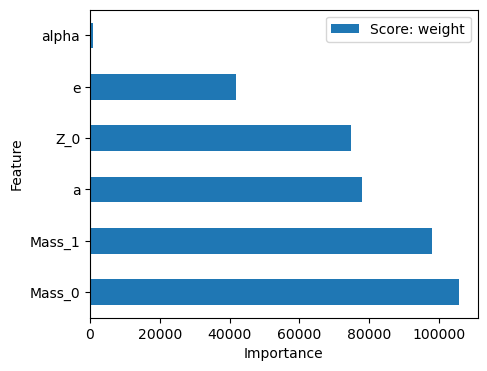

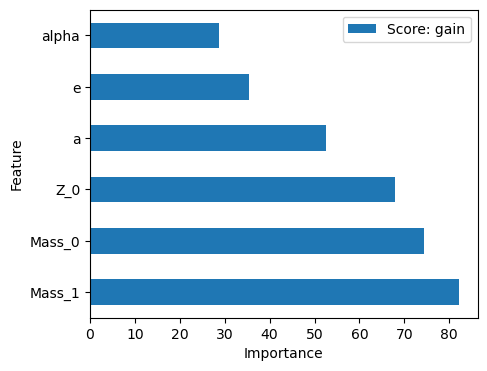

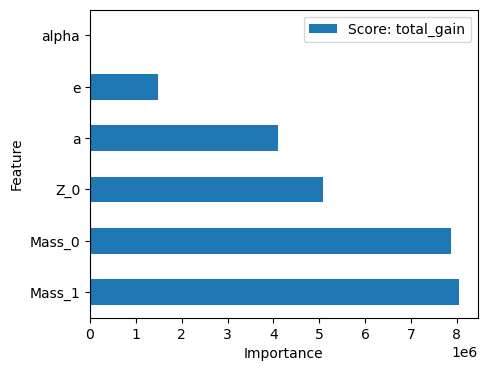

In [76]:
importances=['weight', 'gain', 'total_gain']
for im in importances:
    feature_important = bst.get_score(importance_type=im)
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["Score: "+im]).sort_values(by = "Score: "+im, ascending=False)
    data.plot(kind='barh', figsize = (5,4)) ## plot top 40 features
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.savefig('Figures/lcp/importance_q_yeskicks_'+im+'.png')

## Prediction on test

In [77]:
## distributions of the probability of each class for each record

output_test = xgb.dask.predict(client, bst, features_test).persist() #already a dataframe

## Predicition of the label with Maximum estimation

predicted_label = output_test.idxmax(axis=1).persist()

## Computing the true labels and the predicted

Y_test = label_test.values.compute()

Y_predicted = predicted_label.values.compute()

## Scatter Plot with density

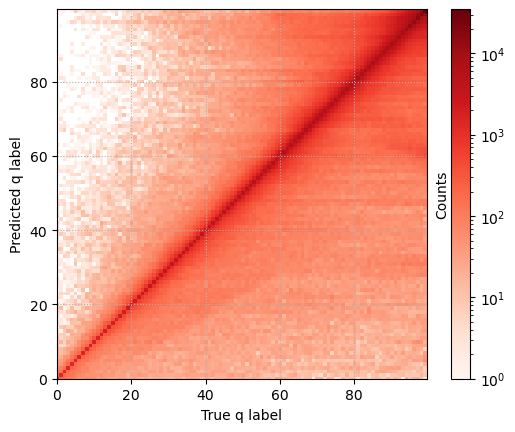

In [121]:
cm=confusion_matrix(Y_test, Y_predicted)
fig = plt.figure()
ax = fig.add_subplot(111)
pp=ax.matshow(cm.T, norm=colors.LogNorm(vmin=1, vmax=cm.max()), cmap='Reds', origin='lower')
cbar=fig.colorbar(pp)
cbar.ax.get_yaxis().labelpad = -50
cbar.ax.set_ylabel('Counts', rotation=90)
plt.grid(linestyle='dotted')
plt.gca().xaxis.tick_bottom()
plt.xlabel('True q label')
plt.ylabel('Predicted q label')
plt.savefig('Figures/lcp/confusion_matrix_labels_yeskicks.png')

In [18]:
def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap='Reds',
                                 norm=colors.LogNorm(vmin=1, vmax=1000))
    fig.colorbar(density, label='Number of points per pixel')

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


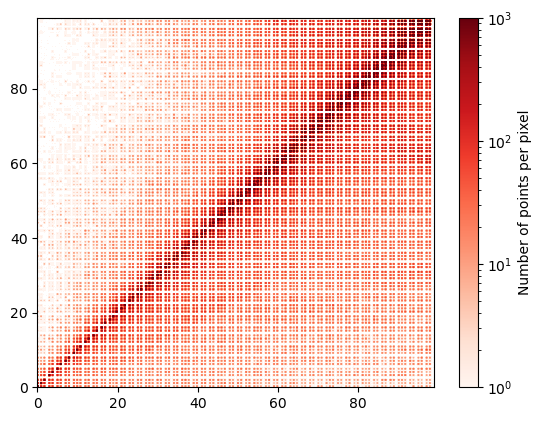

In [19]:
fig = plt.figure()
using_mpl_scatter_density(fig, Y_test, Y_predicted)
plt.show()

# Metrics

In [137]:
counts_test, _ = np.histogram(Y_test, density=True, bins=n_bins)
counts_predicted, _ = np.histogram(Y_predicted, density=True, bins=n_bins)

## Kulback-Leibler metrics

In [138]:
KL_div = scipy.stats.entropy(counts_predicted, counts_test)

KL_div

0.011238856831920125

## JS (limited between 0 and 1 when base=2)

In [139]:
JS_div = JS(counts_test, counts_predicted, base=2)

JS_div

0.06236486359703623

## Histogram of the q distribution

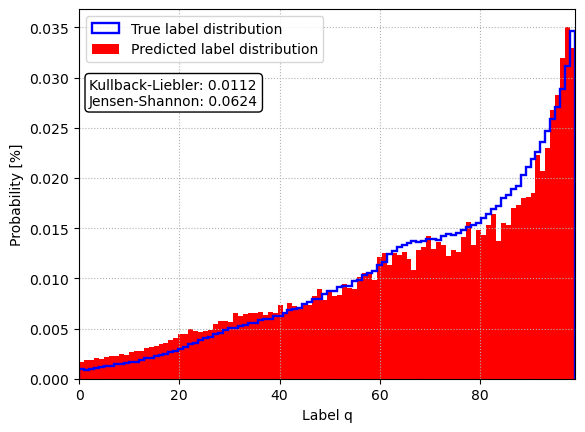

In [167]:
plt.hist(Y_test, bins=n_bins, label = 'True label distribution', histtype='step', density=True, color='blue',  linewidth=1.7)#, linestyle='dashed')
plt.hist(Y_predicted, bins=n_bins, label='Predicted label distribution', density=True, color='red')
plt.xlim(0,99)
plt.grid(linestyle='dotted')
plt.xlabel('Label q')
plt.ylabel('Probability [%]')
plt.text(2, 0.03, "Kullback-Liebler: {:.4f}\nJensen-Shannon: {:.4f}".format(KL_div, JS_div),
         ha="left", va="top",
         bbox=dict(boxstyle="round",
                   ec='black',
                   fc='white',
                   )
         )
plt.legend()
plt.savefig('Figures/lcp/hist_q_yes_kicks.png')

## Histogram of difference of true and prediction

In [168]:
#95% interval 
diff = (Y_predicted-Y_test)
lower=np.quantile(diff, q=0.025) 
upper= np.quantile(diff, q=0.975)
print(lower, upper)

-43.0 24.0


Text(0.5, 0, '$|y_{true}-y_{predicted}|$')

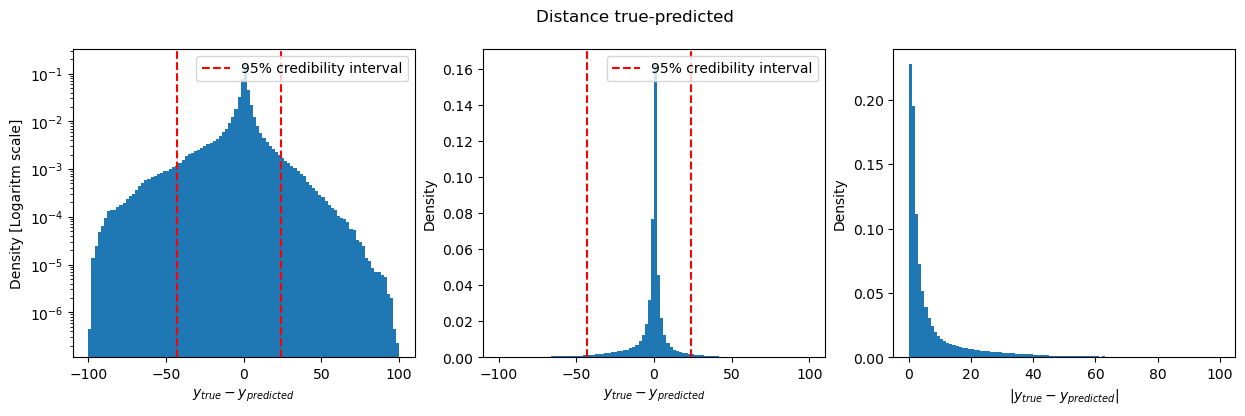

In [169]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

fig.suptitle('Distance true-predicted')
ax[0].hist(-Y_test+Y_predicted, bins=n_bins, density=True, log=True, range=(-n_bins, n_bins));
ax[0].axvline(lower,  label='95% credibility interval', color='red', linestyle='--');
ax[0].axvline(x=upper, color='red', linestyle='--');
ax[0].set_ylabel('Density [Logaritm scale]')
ax[0].set_xlabel(r'$y_{true}-y_{predicted}$')
ax[0].legend()

ax[1].hist(-Y_test+Y_predicted, bins=n_bins, density=True, range=(-n_bins, n_bins));
ax[1].axvline(x=lower, label='95% credibility interval', color='red', linestyle='--');
ax[1].axvline(x=upper, color='red', linestyle='--');
ax[1].set_ylabel('Density')
ax[1].set_xlabel(r'$y_{true}-y_{predicted}$')
ax[1].legend()

ax[2].hist(np.abs(-Y_test+Y_predicted), bins=n_bins, density=True, range=(0, n_bins));
ax[2].set_ylabel('Density')
ax[2].set_xlabel(r'$|y_{true}-y_{predicted}|$')

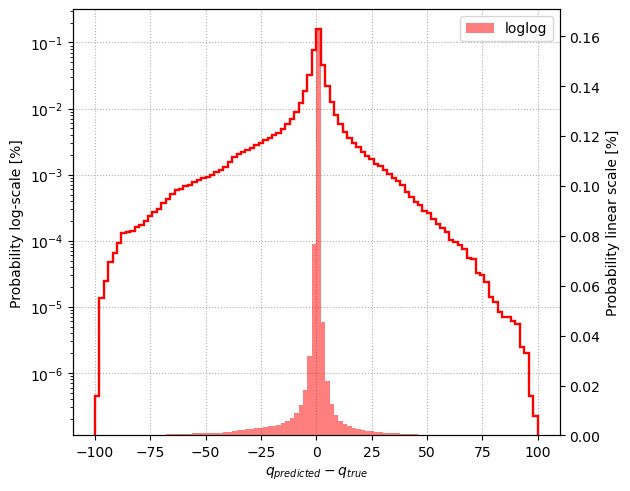

In [212]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax.set_yscale("log")
ax.grid(linestyle='dotted')
# ax2.grid(linestyle='dashed')
ax.hist(Y_predicted-Y_test, bins=n_bins, density=True, range=(-n_bins, n_bins),
        label='log', color='red', histtype='step', linewidth=1.7)
ax2.hist(Y_predicted-Y_test, bins=n_bins, density=True, range=(-n_bins, n_bins),
         alpha=0.5, label='loglog', color='red')

ax2.set_ylabel("Probability linear scale [%]")
ax.set_ylabel("Probability log-scale [%]")
plt.tight_layout()
plt.legend()
ax.set_xlabel(r'$q_{predicted}-q_{true}$')
plt.show()

## Misura della accuracy

In [28]:
## Defining a prediction accurate if not further from the true of a value of threshold
def accuracy_threshold(Y_test, Y_predicted, threshold = 5):
    out=np.abs(Y_test-Y_predicted)
    mask = out < threshold
    return np.sum(mask)/len(Y_test)

In [112]:
accuracy_threshold(Y_test, Y_predicted, 6)

0.6978279003036268

In [30]:
def accuracy_exponential(Y_test, Y_predicted, threshold = 25, tau = 25):
    out = np.exp(-np.abs(Y_test-Y_predicted)/tau)
    out = out[np.abs(Y_test-Y_predicted)<threshold]
    return np.sum(out)/len(Y_test)

In [31]:
accuracy_exponential(Y_test, Y_predicted)

0.7939089584865444

## Grid Search with For Loops

## Clustering of probability distribution

In [32]:
# Defininf a function to order the peaks of the probability distribution
def extract_top_values(row, n_top=3):
    row_sorted = np.sort(row)[::-1]
    return row_sorted[:n_top]

In [33]:
# Defininf a function to order the peaks of the probability distribution
def extract_id_top_values(row, n_top=3):
    idx_sorted = np.argsort(row)[::-1]
    return np.array(idx_sorted)[:n_top]

In [34]:
# applying the previous function
top_values = output_test.apply(extract_top_values, axis=1, meta=(None, 'object'))
idx_top_values = output_test.apply(extract_id_top_values, axis=1, meta=(None, 'object'))

## Creating a dataframe with all the test set information

In [35]:
top_values = top_values.compute()
top_values = pd.DataFrame(top_values.to_list(), columns = ['1', '2', '3'])

idx_top_values = idx_top_values.compute()
idx_top_values = pd.DataFrame(idx_top_values.to_list(), columns = ['1', '2', '3'])

for col in idx_top_values.columns:
    top_values[f'idx_{col}']=idx_top_values[col].values   
    
top_values['Y_predicted']=Y_predicted
top_values['Y_test']=Y_test
top_values['Delta_Y']=np.abs(Y_predicted-Y_test)

#adding feature
X_test = features_test.compute()
for col in X_test.columns:
    top_values[col]=X_test[col].values

In [36]:
top_values

,1,2,3,idx_1,idx_2,idx_3,Y_predicted,Y_test,Delta_Y,Mass_0,Z_0,Mass_1,a,e,alpha
0,0.024285,0.023191,0.020827,65,54,63,65,43,22,32.011,0.0004,19.925,65.4,0.2330,1.0
1,0.071007,0.054326,0.047469,95,89,93,95,82,13,60.831,0.0004,42.856,503.0,0.0606,1.0
2,0.134418,0.080951,0.065953,86,87,84,86,85,1,58.943,0.0004,51.689,40200.0,0.2780,1.0
3,0.080416,0.068563,0.051379,78,83,85,78,83,5,68.488,0.0004,45.524,22400.0,0.1760,1.0
4,0.184966,0.090798,0.063075,70,71,69,70,69,1,39.568,0.0004,32.209,13700.0,0.3440,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2247820,0.056821,0.053607,0.043850,89,98,93,89,98,9,47.891,0.0100,32.363,14100.0,0.0238,3.0
2247821,0.088538,0.088240,0.053187,79,80,81,79,79,0,55.556,0.0100,48.744,26000.0,0.4070,3.0
2247822,0.060485,0.044898,0.028923,52,49,54,52,70,18,38.862,0.0100,37.341,305.0,0.3260,3.0
2247823,0.190098,0.131862,0.074389,40,42,43,40,40,0,106.439,0.0100,43.318,5160.0,0.6120,3.0


In [37]:
idx_diff = top_values['idx_1']-top_values['idx_2']

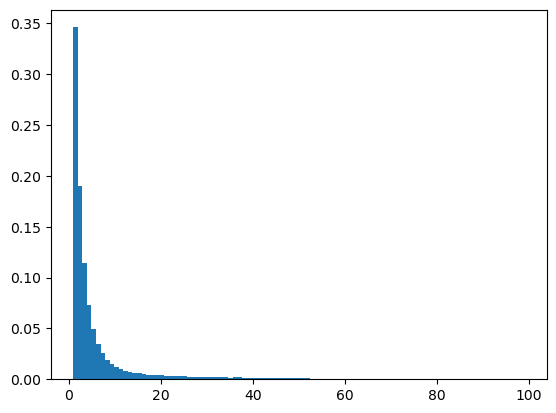

In [113]:
plt.hist(np.abs(idx_diff), bins=99, density=True);

# Some interesting representations

## All the points

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


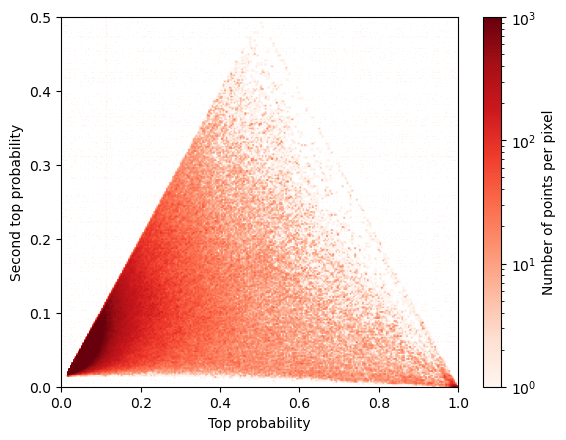

In [39]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values['1'], top_values['2'])
plt.xlabel('Top probability')
plt.ylabel('Second top probability')
plt.xlim(0,1)
plt.ylim(0,0.5)
plt.show()

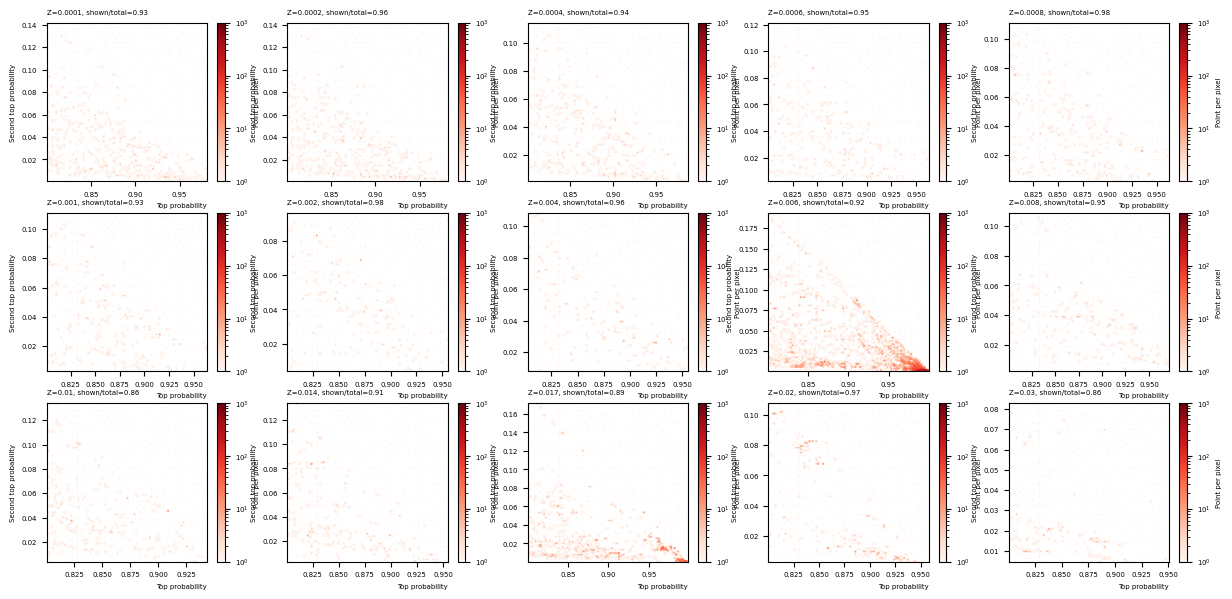

In [129]:
fontsize=5
fig = plt.figure(figsize=(15, 7))
Z=np.unique(top_values.Z_0)
for i, z in enumerate(Z):
    ax = fig.add_subplot(3, 5, i+1, projection='scatter_density')
    density = ax.scatter_density(x= top_values[(top_values.Z_0==z) & (top_values.Delta_Y == 0) & (top_values['1']>=0.8)]['1'],
                       y=top_values[(top_values.Z_0==z) & (top_values.Delta_Y == 0) & (top_values['1']>=0.8)]['2'],
                       cmap='Reds',
                       norm=colors.LogNorm(vmin=1, vmax=1000))
    ax.set_xlabel('Top probability', fontsize=fontsize, loc='right')
    ax.tick_params(labelsize=fontsize)
    ax.set_ylabel('Second top probability', fontsize=fontsize)
    # ax.set_xlim(0,1)
    # ax.set_ylim(0,0.5)
    
    
    cbar = fig.colorbar(density, ax=ax)
    cbar.ax.set_ylabel(ylabel='Point per pixel', fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    # cbar.set_label(fontsize=fontsize, label='Number of points per pixel')
    
    ax.set_title(f'Z={z}, shown/total={len(top_values[(top_values.Z_0==z) & (top_values.Delta_Y == 0) & (top_values["1"]>=0.8)])/len(top_values[(top_values.Z_0==z) & (top_values["1"]>=0.8)]):.2f}',
                 fontsize=fontsize,
                 loc='left')
    
# sns.scatterplot(data = top_values, x= '1', y='2', hue='Z_0', size=0.001)

## Point correctly predicted

In [107]:
top_values_0 = top_values[top_values['Delta_Y']==0]

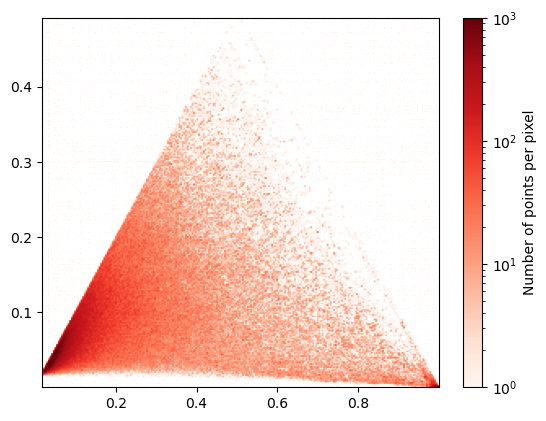

In [108]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values_0['1'], top_values_0['2'])
plt.show()

### Check for the Mass dependency

In [ ]:
fig = plt.figure()
using_mpl_scatter_density(fig,
                          top_values_0[top_values_0['Mass_0']<40]['1'],
                          top_values_0[top_values_0['Mass_0']<40]['2'])
plt.show()

## Points with wrong prediction

In [116]:
top_values_15 = top_values[top_values['Delta_Y']>=15]

<Axes: xlabel='1', ylabel='2'>

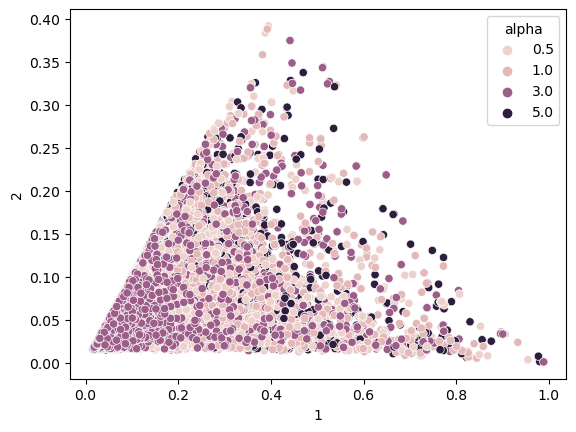

In [117]:
sns.scatterplot(data = top_values_15, x= '1', y='2', hue='alpha', )


/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


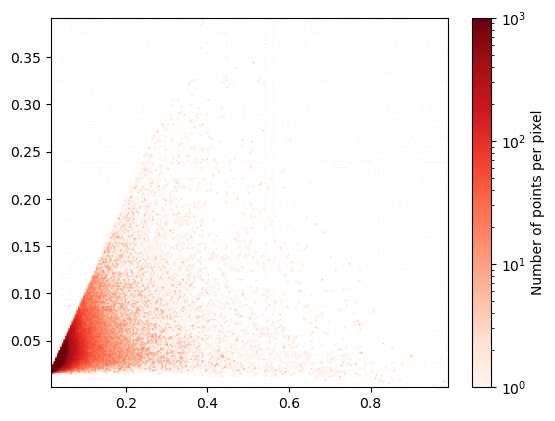

In [118]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values_15['1'], top_values_15['2'])
plt.show()

### Searching for descrepancies in other features

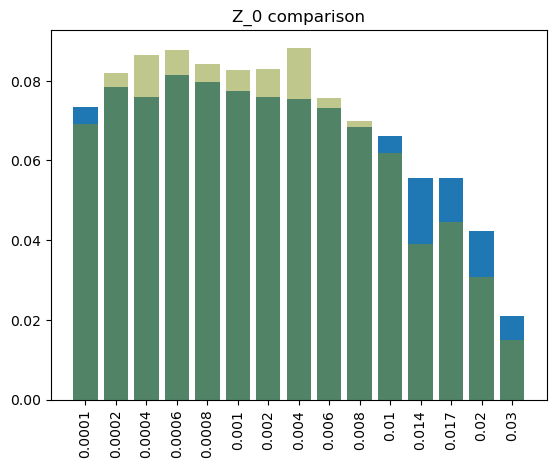

In [119]:
labels, counts = np.unique(top_values['Z_0'].values, return_counts=True)
plt.bar( labels.astype(str), counts/counts.sum())
plt.xticks(rotation=90);

labels, counts = np.unique(top_values_15['Z_0'].values, return_counts=True)
plt.bar( labels.astype(str), counts/counts.sum(), alpha=0.3)
plt.xticks(rotation=90);
plt.title('Z_0 comparison');

labels, counts = np.unique(top_values_15['Z_0'].values, return_counts=True)
plt.bar( labels.astype(str), counts/counts.sum(), alpha=0.3)
plt.xticks(rotation=90);
plt.title('Z_0 comparison');

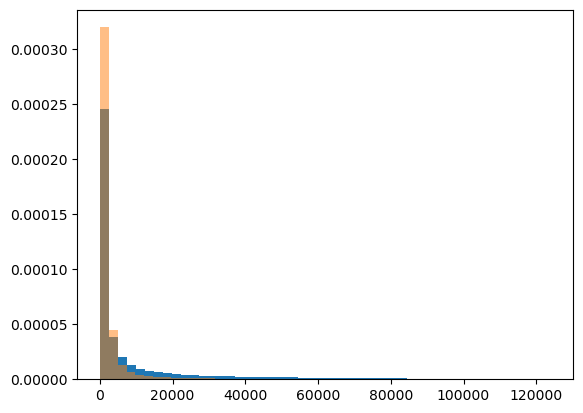

In [125]:
plt.hist(top_values['a'], density=True, bins=50);
plt.hist(top_values_15['a'], density=True, bins=50, alpha=0.5);

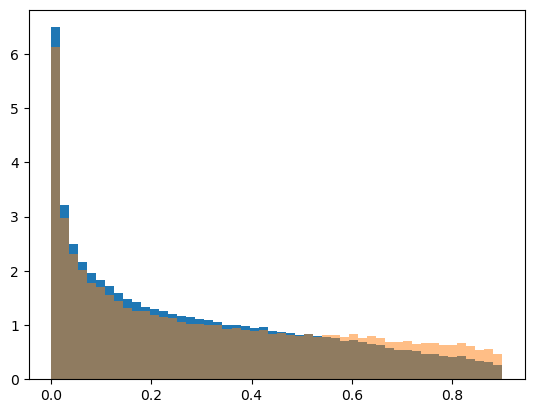

In [121]:
plt.hist(top_values['e'], density=True, bins=50, );
plt.hist(top_values_15['e'], density=True, bins=50, alpha=0.5);

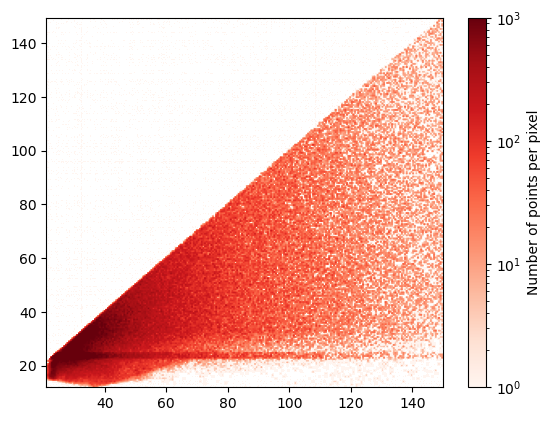

In [122]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values['Mass_0'], top_values['Mass_1'])
plt.show()

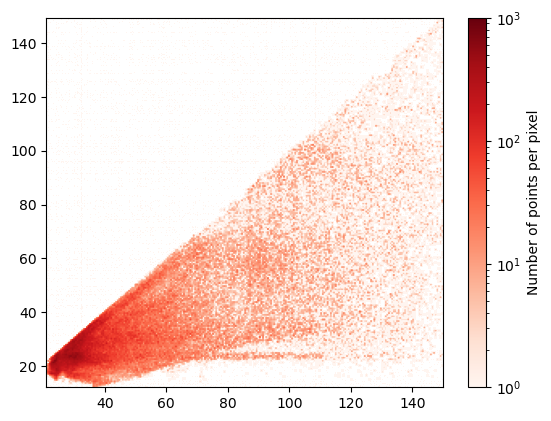

In [123]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values_15['Mass_0'], top_values_15['Mass_1'])
plt.show()

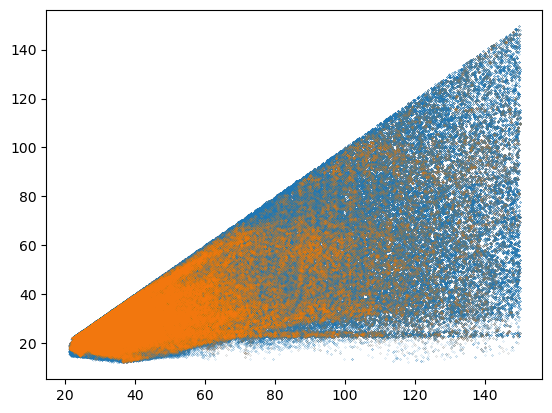

In [124]:
plt.scatter(top_values['Mass_0'], top_values['Mass_1'], s=0.01)
plt.scatter(top_values_15['Mass_0'], top_values_15['Mass_1'], alpha=0.5, s=0.01)

## Attempt of 3D plot

In [ ]:
fig=plt.figure()
ax=plt.axes(projection='3d')
ax.scatter3D(top_values_15['1'], top_values_15['2'], top_values_15['3'], s=0.01)

## Some simple statistics

In [115]:
print(f'Fraction of data in the flat region: {len(top_values[top_values["1"]<0.2])/len(top_values):.2f}')

print(f'Fraction of exactly guessed labels: {len(top_values_0)/len(top_values):.2f}')

print( f"Exactly guessed label in flat region / total points in flat region:{  len(top_values_0[top_values_0['1']<0.2])/len(top_values[top_values['1']<0.2])  :.2f}"   )

print( f"Exactly guessed label in flat region / total exactly flat labels:{  len(  top_values_0[ top_values_0[ '1' ]<0.2 ] )/len(top_values_0)  :.2f}"   )



# len(top_values[top_values['1']<0.2])/len(top_values)

Fraction of data in the flat region: 0.82
Fraction of exactly guessed labels: 0.23
Exactly guessed label in flat region / total points in flat region:0.16
Exactly guessed label in flat region / total exactly flat labels:0.58


In [ ]:
# cluster.close()

# Clustering by eye

In [132]:
one_peak = np.zeros(len(top_values))
one_peak[top_values['1']>0.8] = 1
top_values['Cluster_peak'] = one_peak.astype(int)

# Plot of cluster

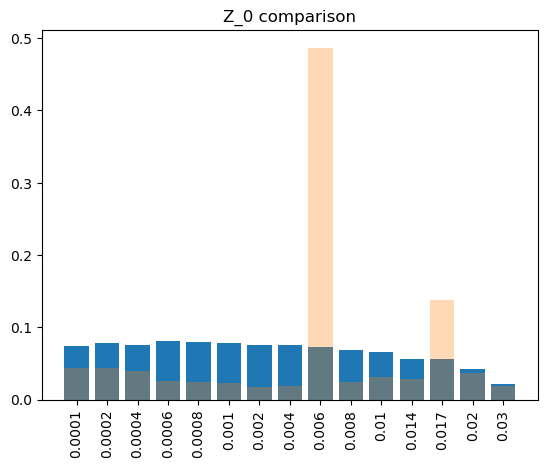

In [136]:
labels, counts = np.unique(top_values['Z_0'].values, return_counts=True)
plt.bar( labels.astype(str), counts/counts.sum())
plt.xticks(rotation=90);

labels, counts = np.unique(top_values[top_values.Cluster_peak==1]['Z_0'].values, return_counts=True)
plt.bar( labels.astype(str), counts/counts.sum(), alpha=0.3)
plt.xticks(rotation=90);
plt.title('Z_0 comparison');


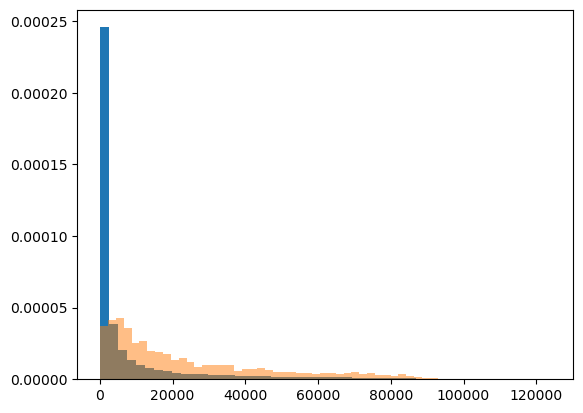

In [137]:
plt.hist(top_values['a'], density=True, bins=50);
plt.hist(top_values[top_values.Cluster_peak==1]['a'], density=True, bins=50, alpha=0.5);

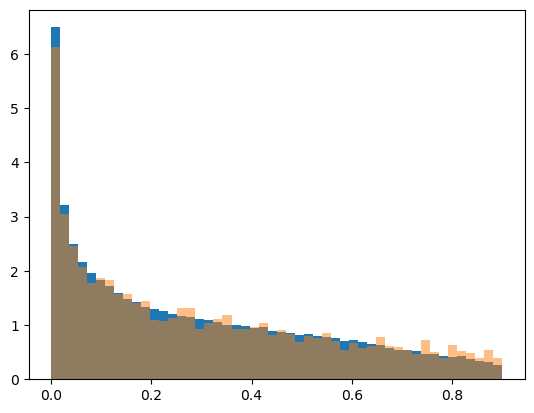

In [138]:
plt.hist(top_values['e'], density=True, bins=50, );
plt.hist(top_values[top_values.Cluster_peak==1]['e'], density=True, bins=50, alpha=0.5);

In [142]:
bhbh_test.columns

Index(['name', 'Mass_0', 'Z_0', 'SN_0', 'Mass_1', 'SN_1', 'a', 'e', 'alpha',
       'Mass_0_out', 'Mass_1_out', 'Semimajor', 'Eccentricity', 'GWtime',
       'BWorldtime', 'RLO', 'CE', 'BSN', 'No_Kick', 'tdelay', 'Mass_max_out',
       'q', 'Mass_chirp', 'label'],
      dtype='object')

In [144]:
bhbh_test[bhbh_test.Z_0==0.006].groupby("No_Kick").count().compute()

,name,Mass_0,Z_0,SN_0,Mass_1,SN_1,a,e,alpha,Mass_0_out,...,GWtime,BWorldtime,RLO,CE,BSN,tdelay,Mass_max_out,q,Mass_chirp,label
No_Kick,,,,,,,,,,,,,,,,,,,,,
0.0,29482,29482,29482,29482,29482,29482,29482,29482,29482,29482,...,29482,29482,29482,29482,29482,29482,29482,29482,29482,29482
1.0,45831,45831,45831,45831,45831,45831,45831,45831,45831,45831,...,45831,45831,45831,45831,45831,45831,45831,45831,45831,45831
2.0,88916,88916,88916,88916,88916,88916,88916,88916,88916,88916,...,88916,88916,88916,88916,88916,88916,88916,88916,88916,88916
3.0,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
